In [51]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

%matplotlib inline
from IPython.display import clear_output

import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.utils.prune as prune

In [52]:
# Set seed for Python's random module
random.seed(42)
# Set seed for NumPy
np.random.seed(42)
# Set seed for PyTorch
torch.manual_seed(42)

In [53]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001, restore_best_weights=True):
        """
        Args:
            patience (int): How many epochs to wait after last improvement
            min_delta (float): Minimum change to qualify as an improvement
            restore_best_weights (bool): Whether to restore model weights from the best epoch
        """
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_score = None
        self.best_weights = None
        self.counter = 0
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        score = -val_loss  # We use negative because greater score = better performance
        
        if self.best_score is None:
            self.best_score = score
            if self.restore_best_weights:
                self.best_weights = self._get_weights(model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            if self.restore_best_weights:
                self.best_weights = self._get_weights(model)
            self.counter = 0
            
    def _get_weights(self, model):
        return {name: param.clone().detach() for name, param in model.state_dict().items()}
    
    def restore_weights(self, model):
        if self.restore_best_weights and self.best_weights is not None:
            model.load_state_dict(self.best_weights)

In [54]:
"""
The following function globally prunes all weights (not including the bias vectors) 
in nn.Linear layers in the model using L1 unstructured pruning,
reinitializes the surviving weights using Kaiming uniform initialization,
and installs a forward pre-hook to enforce that the pruned weights remain zero.

Inputs:
    model (nn.Module): The model to prune.
    amount (float): Fraction of weights to prune globally (e.g., 0.8 for 80%).

Output: The pruned model.
"""
def global_prune(model, amount):
    # Collect all Linear layers and their weights
    parameters_to_prune = [
        (module, 'weight') 
        for module in model.modules()
        if isinstance(module, nn.Linear)
    ]

    # Perform global L1 unstructured pruning
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )

    # Process each pruned layer
    for module, param_name in parameters_to_prune:
        # Extract and store mask as buffer
        mask = getattr(module, f"{param_name}_mask").clone()
        module.register_buffer("pruning_mask", mask)
        
        # Reinitialize unpruned weights while preserving zeros
        with torch.no_grad():
            # Get current weights (already pruned)
            weight = getattr(module, param_name)
            
            # Create new initialization
            new_weights = torch.empty_like(weight)
            nn.init.kaiming_uniform_(new_weights, mode='fan_in', nonlinearity='relu')
            
            # Apply mask and update weights
            weight.data.copy_(new_weights * mask)

        # Remove PyTorch's pruning buffers
        prune.remove(module, param_name)

    # Register forward pre-hook to maintain pruning
    def apply_mask(module, inputs):
        if hasattr(module, "pruning_mask"):
            mask = module.pruning_mask
            with torch.no_grad():
                module.weight.data.mul_(mask)  # In-place multiplication

    # Add hooks to all pruned modules
    for module, _ in parameters_to_prune:
        if hasattr(module, "pruning_mask"):
            module.register_forward_pre_hook(apply_mask)

    return model

In [55]:
n = 2*10**4    # This includes 50% training data, 25% validationm data and 25% testing data. 
d = 20
sigma = 0.5

# Define regression function
def reg_func(x):
    y = np.exp(x[1] + x[2]) + 4 * x[3]**2
    return y

# Generate X and Y
X = np.random.uniform(-1 , 1, (n, d))
Y = np.zeros(n)
for i in range(n):
    Y[i] = reg_func(X[i,:]) + np.random.normal(0, sigma, 1)[0]

# Generate Omega, which has iid Ber(0.7) coordinates, independent of X
# The Bayes risk for this model is approximately 0.88025 + sigma^2
Omega = np.random.binomial(1, 0.7, (n, d))
Z_ZI = X * Omega

In [56]:
# Split data into 50% training data, 25% validation data, 25% testing data
Z_ZI_train = Z_ZI[0:int(n/2), :]
Z_ZI_val = Z_ZI[int(n/2):int(3*n/4), :]
Z_ZI_test = Z_ZI[int(3*n/4):n, :]
Omega_train = Omega[0:int(n/2), :]
Omega_val = Omega[int(n/2):int(3*n/4), :]
Omega_test = Omega[int(3*n/4):n, :]
Y_train = Y[0:int(n/2)]
Y_val = Y[int(n/2):int(3*n/4)]
Y_test = Y[int(3*n/4):n]

# Convert data into tensors
Z_ZI_train = torch.tensor(Z_ZI_train, dtype=torch.float32)
Z_ZI_val = torch.tensor(Z_ZI_val, dtype=torch.float32)
Z_ZI_test = torch.tensor(Z_ZI_test, dtype=torch.float32)
Omega_train = torch.tensor(Omega_train, dtype=torch.float32)
Omega_val = torch.tensor(Omega_val, dtype=torch.float32)
Omega_test = torch.tensor(Omega_test, dtype=torch.float32)
Y_train = torch.tensor(Y_train.reshape(-1, 1), dtype=torch.float32)
Y_val = torch.tensor(Y_val.reshape(-1, 1), dtype=torch.float32)
Y_test = torch.tensor(Y_test.reshape(-1, 1), dtype=torch.float32)

In [57]:
# Define the class of Pattern Embedding Neural Networks (PENN)
class PENN(nn.Module):
    def __init__(self):
        super().__init__()
        embedding_dim = 3
        
        # Construct the neural network f1
        self.f1 = nn.Sequential(
            nn.Linear(d, 70),  
            nn.ReLU(),
            nn.Linear(70, 70), 
            nn.ReLU(),
            nn.Linear(70, 70), 
            nn.ReLU()
        )

        # Construct the neural network f2, i.e. the embedding function
        self.f2 = nn.Sequential(
            nn.Linear(d, 30),  
            nn.ReLU(),
            nn.Linear(30, 30),  
            nn.ReLU(),
            nn.Linear(30, embedding_dim)
        )

        
        # Construct the neural network f3
        self.f3 = nn.Sequential(
            nn.Linear(70 + embedding_dim, 70),
            nn.ReLU(),
            nn.Linear(70, 70),
            nn.ReLU(),
            nn.Linear(70, 70),
            nn.ReLU(),
            nn.Linear(70, 1)  
        )
    
    # Combine f1, f2 and f3 to construct the Pattern Embedding Neural Network
    def forward(self, z, omega):
        # Compute the output of f1 and f2
        f1_output = self.f1(z)
        f2_output = self.f2(omega)
        
        # Concatenate the output of f1 and f2
        combined_features = torch.cat((f1_output, f2_output), dim=1)
        
        # Apply the combined network
        final_output = self.f3(combined_features)
        
        return final_output

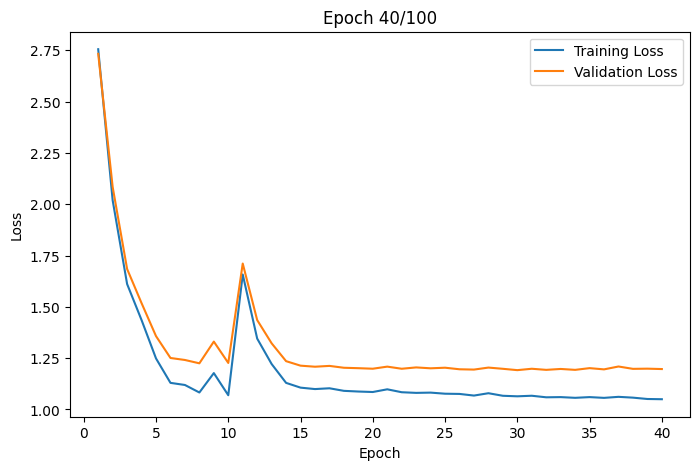

Early stopping triggered at epoch 40.
MSE: 1.1749014854431152
Excess risk: 0.04465150833129883


In [58]:
lr = 0.001
epochs = 100
weight_decay = 0.001

model_PENN = PENN()
PENN_train_data = TensorDataset(Z_ZI_train, Omega_train, Y_train)
PENN_train_loader = DataLoader(dataset = PENN_train_data, batch_size=200, shuffle=True)

optimizer = optim.Adam(model_PENN.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

train_losses = []
val_losses = []

for epoch in range(epochs):

    model_PENN.train()
    if epoch == 10:
        model_PENN = global_prune(model_PENN, amount = 0.9)
    for z_batch, omega_batch, y_batch in PENN_train_loader:
        optimizer.zero_grad()
        pred = model_PENN(z_batch, omega_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        
    # Record training and validation losses
    model_PENN.eval()
    with torch.no_grad():
        train_losses.append(loss_fn(model_PENN(Z_ZI_train, Omega_train), Y_train))
        val_losses.append(loss_fn(model_PENN(Z_ZI_val, Omega_val), Y_val))

    # Live plotting (Jupyter only)
    clear_output(wait=True)  
    plt.figure(figsize=(8, 5))
    plt.plot(range(1,epoch+2), train_losses, label='Training Loss')
    plt.plot(range(1,epoch+2), val_losses, label='Validation Loss')
    plt.title(f'Epoch {epoch+1}/{epochs}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    if epoch >= 10:
        early_stopping(val_losses[-1], model_PENN)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break
 
 
early_stopping.restore_weights(model_PENN)

# Print mean squared error (MSE) on testing data and excess risk (testing loss - bayes risk
model_PENN.eval()
# Mean squared error (MSE) on testing data
print(f'MSE: {loss_fn(model_PENN(Z_ZI_test, Omega_test), Y_test)}')
# Excess risk (MSE - Bayes risk)
print(f'Excess risk: {loss_fn(model_PENN(Z_ZI_test, Omega_test), Y_test) - 0.88025 - sigma**2}')